In [77]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import os
torch.set_printoptions(precision=5)
output_dir = "C:/Users/lix23/Desktop/CPM/"

In [89]:
def parse_args():
  parser = argparse.ArgumentParser()

  parser.add_argument('--z_dim', default=3, type=int) 
  parser.add_argument('--x_dim', default=3, type=int) 
  parser.add_argument('--y_dim', default=3, type=int)
  parser.add_argument('--K_dim', default=3, type=int)
  parser.add_argument('--output_layer', default=[32,64]) 
  parser.add_argument('--num_samples', default=100) 
  parser.add_argument('--langevin_K', default=100)
  parser.add_argument('--langevin_s', default=0.1) 
  parser.add_argument('--kappa', default=10)
  parser.add_argument('--penalties', default=[10,20,50,100], type=int)
  parser.add_argument('--time_embed_dim', default=16, type=int)
  
  parser.add_argument('--epoch', default=50)
  parser.add_argument('--decoder_iteration', default=20)
  parser.add_argument('--nu_iteration', default=20)
  parser.add_argument('--decoder_lr', default=0.1)
  parser.add_argument('--decoder_thr', default=0.001)
  parser.add_argument('--iter_thr', default=5)
  parser.add_argument('--loglik_thr', default=0.00001)

  parser.add_argument('--use_data', default='XXX')
  parser.add_argument('--num_seq', default=100)
  parser.add_argument('--num_time', default=200)
  parser.add_argument('--data_dir', default='./data/')
  parser.add_argument('-f', required=False)

  args, _ = parser.parse_known_args()
  return args


args = parse_args()
print(args)
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print('[INFO]', device)



#################
# LOSS FUNCTION #   
#################

# Write a loss function for infer_z() use. This version is idendity matrix case.

# def mixture_of_gaussians_loss(y, pi, mean):
#     """
#     y:    (N, D)
#     pi:   (N, K)
#     mean: (N, K, D)
#     """
#     N, K, D = mean.shape
    
#     # expand y -> (N, K, D)
#     y_expand = y.unsqueeze(1).expand(-1, K, -1)
    
#     # squared Euclidean distance ||y - mu||^2
#     diff_sq = torch.sum((y_expand - mean) ** 2, dim=-1)   # (N, K)
    
#     # Gaussian pdf with identity covariance
#     norm_const = 1.0 / ((2 * torch.pi) ** (D / 2))
#     pdf_vals = norm_const * torch.exp(-0.5 * diff_sq)     # (N, K)
    
#     # mixture: sum_k pi * pdf
#     weighted = pi * pdf_vals
#     total = torch.sum(weighted, dim=1)                    # (N,)
    
#     # negative log-likelihood
#     nll = -torch.sum(torch.log(total + 1e-10))
#     return nll

# Finished 2025-08-20 9:48 AM PST

# Another Version, diagonal case.


def mixture_of_gaussians_loss(y, pi, mean, sigma):
    """
    y:     (N, D)
    pi:    (N, K)
    mean:  (N, K, D)
    sigma: (N, K, D)  
    """
    N, K, D = mean.shape

    # expand y to (N, K, D)
    y_expand = y.unsqueeze(1).expand(-1, K, -1)

    # (y - mu)^2 / sigma
    diff = y_expand - mean
    mahal = torch.sum((diff**2) / (sigma + 1e-8), dim=2)  # (N, K)

    # log det of diagonal cov
    log_det = torch.sum(torch.log(sigma + 1e-8), dim=2)  # (N, K)

    # log Gaussian pdf
    log_prob = -0.5 * (D * np.log(2*np.pi) + log_det + mahal)  # (N, K)

    # mixture likelihood
    weighted = pi * torch.exp(log_prob)  # (N, K)
    total_prob = torch.sum(weighted, dim=1)  # (N,)

    # negative log-likelihood
    nll = -torch.sum(torch.log(total_prob + 1e-12))
    return nll





Namespace(z_dim=3, x_dim=3, y_dim=3, K_dim=3, output_layer=[32, 64], num_samples=100, langevin_K=100, langevin_s=0.1, kappa=10, penalties=[10, 20, 50, 100], time_embed_dim=16, epoch=50, decoder_iteration=20, nu_iteration=20, decoder_lr=0.1, decoder_thr=0.001, iter_thr=5, loglik_thr=1e-05, use_data='XXX', num_seq=100, num_time=200, data_dir='./data/', f=None)
[INFO] cuda:0


In [79]:
###################
# LOAD SAVED DATA #
###################


import pandas as pd
import numpy as np
import torch


x_df = pd.read_csv("x_all.csv")
z_df = pd.read_csv("z_all.csv")
y_df = pd.read_csv("y_all.csv")
meta_df = pd.read_csv("data_all.csv")

x_all = x_df.values   # (20000, 3)
z_all = z_df.values   # (20000, 3)
y_all = y_df.values   # (20000, 3)

# Check dimension match 
X_rec = x_all.reshape(args.num_time, args.num_samples, args.x_dim)
# Z_rec = z_all.reshape(args.num_time, args.num_samples, args.z_dim)
Y_rec = y_all.reshape(args.num_time, args.num_samples, args.y_dim)

X_torch = torch.tensor(X_rec, dtype=torch.float32)
# Z_torch = torch.tensor(Z_rec, dtype=torch.float32)
Y_torch = torch.tensor(Y_rec, dtype=torch.float32)


# Initialize the weights
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param.data, -0.05, 0.05)


In [80]:
#########
# MODEL #
#########

class CPD(nn.Module):
  def __init__(self, args, half):
    super(CPD, self).__init__()

    self.d = args.z_dim
    self.p = args.x_dim
    self.K = args.K_dim           # mixture components
    self.D = args.y_dim           # output dim = 3
    self.T = int(args.num_time/2) if half else args.num_time

    self.l1 = nn.Linear(self.d + self.p, args.output_layer[0])
    self.l2 = nn.Linear(args.output_layer[0], args.output_layer[1])

    self.l3_pi    = nn.Linear(args.output_layer[1], self.K)          # (TB, K)
    self.l3_mean  = nn.Linear(args.output_layer[1], self.K * self.D) # (TB, K*3)
    self.l3_sigma = nn.Linear(args.output_layer[1], self.K * self.D) # (TB, K*3)
    
  def forward(self, x, z):
    output = torch.cat([x, z], dim=1)
    output = self.l1(output).tanh()
    output = self.l2(output).tanh()

    pi = self.l3_pi(output).softmax(dim=1)                  # (TB, K)
    mean = self.l3_mean(output).reshape(-1, self.K, self.D) # (TB, K, D)
    sigma = F.softplus(self.l3_sigma(output)).reshape(-1, self.K, self.D) + 1e-6

    # covs = []
    # for k in range(self.K):
    #     # cov_matrix = torch.diag_embed(sigma[:, k, :]**2)    # (TB, D, D)
    #     cov_matrix = torch.diag_embed(torch.ones(self.D).to(device))
    #     covs.append(cov_matrix)
    # covs = torch.stack(covs, dim=1)  # (TB, K, D, D)

    return pi, mean, sigma

  def infer_z(self, x, z, y, mu_repeat, args):
    """
    x: (T*B, p)
    z: (T*B, d)
    y: (T*B, D)   # target
    mu_repeat: (T*B, d)  # prior mean for z
    """
    for k in range(args.langevin_K):
        z = z.detach().clone().requires_grad_(True)

        # forward
        pi, mean, sigma = self.forward(x, z)

        # compute NLL loss
        nll = mixture_of_gaussians_loss(y, pi, mean, sigma)

        # gradient wrt z
        z_grad_nll = torch.autograd.grad(nll, z)[0]

        # Langevin noise
        noise = torch.randn_like(z).to(z.device)

        # update
        z = z + args.langevin_s * (-z_grad_nll - (z - mu_repeat)) \
              + torch.sqrt(torch.tensor(2.0 * args.langevin_s)) * noise

    return z.detach()





In [81]:
x_all = pd.read_csv("x_all.csv").values   # (T*N, dx)
z_all = pd.read_csv("z_all.csv").values   # (T*N, dz)
y_all = pd.read_csv("y_all.csv").values   # (T*N, dy)


x_input = torch.tensor(x_all, dtype=torch.float32).to(device)
z_input = torch.tensor(z_all, dtype=torch.float32).to(device)
y_input = torch.tensor(y_all, dtype=torch.float32).to(device)

In [ ]:
def learn_one_seq_penalty(args,x_input, y_input, penalty):
    m = args.num_samples
    kappa = args.kappa
    d = args.z_dim
    pen_iter = 0
    penalty = penalty
    early_stopping = False
    stopping_count = 0 # for ADMM
    # create matrix X and vector 1
    T = args.num_time
    ones_col = torch.ones(T, 1).to(device)
    X = torch.zeros(T, T-1).to(device)
    i, j = torch.tril_indices(T, T-1, offset=-1)
    X[i, j] = 1 # Group Fused Lasso
    old_loglik = -float('inf')
    loglik_train_holder = []
    loglik_test_holder = []
    mu_diff_holder = []
    decoder_loss_holder = []
    CV_holder = []
    best_mu = torch.zeros(T,d)
    best_loglik = torch.zeros(1)
    best_CV = -float('inf') # Coefficient of Variation
    best_CV_iter = 0

    # initialize mu, nu, w, with dim T by d of zeros
    mu = torch.zeros(T, d).to(device)
    nu = torch.zeros(T, d).to(device)
    w = torch.zeros(T, d).to(device)

    mu_old = mu.detach().clone()
    nu_old = nu.detach().clone()

    print(y_input.shape)
    # Use y_input directly, no need to repeat

    model = CPD(args, half = False).to(device)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.decoder_lr)
    for learn_iter in range(args.epoch):
      print('\n[INFO] Epoch', learn_iter)
      ####################
      # GENERATE SAMPLES #
      ####################
      # create repeated version of mu, from (T by d) to (Tm by d)
      mu_repeat = mu.repeat_interleave(m, dim=0) # Tm by d
      init_z = torch.randn(T*m, d).to(device) # Tm by d, starts from N(0,1)
      sampled_z_all = model.infer_z(x_input, init_z, y_input, mu_repeat, args) # Tm by d

      ################
      # UPDATE PRIOR # 
      ################
      expected_z = sampled_z_all.clone().reshape(T,m,d) # T by m by d
      expected_z = expected_z.mean(dim=1) # T by d
      mu = ( expected_z + kappa * (nu-w) ) / ( 1.0 + kappa )
      mu = mu.detach().clone()

      ##################
      # UPDATE DECODER #
      ##################
      inner_loss = float('inf')
      for decoder_iter in range(args.decoder_iteration):
          optimizer.zero_grad()
          pi, mean, sigma  = model(x_input, sampled_z_all) # Tm by n by n 
          loss = mixture_of_gaussians_loss(y_input, pi, mean, sigma)/m
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), 1)
          optimizer.step()

      #########################
      # UPDATE BETA AND GAMMA #
      #########################
    
      gamma = nu[0, :].unsqueeze(0) # row vector
      beta = torch.diff(nu, dim=0)

      for nu_iter in range(args.nu_iteration):
          # update beta once (t range from 1 to 99, NOT 1 to 100)
          for t in range(T-1): 
            beta_without_t = beta.detach().clone()
            X_without_t = X.detach().clone()
            beta_without_t[t,:] = torch.zeros(d) # make this row zeros
            X_without_t[:,t] = torch.zeros(T) # make this column zeros
            bt = kappa * torch.mm( X[:,t].unsqueeze(0), mu + w - torch.mm(ones_col, gamma) - torch.mm(X_without_t, beta_without_t) )
            bt_norm = torch.norm(bt, p=2)

            # UPDATE: soft-thresholding
            if bt_norm < penalty:
                beta[t,:] = torch.zeros(d)
            else:
                beta[t,:] = 1 / (kappa * torch.norm(X[:,t], p=2)**2) * (1 - penalty/bt_norm) * bt
            beta = beta.detach().clone()

          # update gamma
          gamma = torch.mean(mu + w - torch.mm(X, beta), dim=0).unsqueeze(0).detach().clone()

      # recollect nu
      nu = torch.mm(ones_col, gamma) + torch.mm(X, beta)
      nu = nu.detach().clone()

      ############
      # UPDATE W # 
      ############

      w = mu - nu + w
      w = w.detach().clone()

      ############
      # RESIDUAL # 
      ############

      primal_residual = torch.sqrt(torch.mean(torch.square(mu - nu)))
      dual_residual = torch.sqrt(torch.mean(torch.square(nu - nu_old)))

      # if primal_residual > 10.0 * dual_residual:
      #     kappa *= 2.0
      #     w *= 0.5
      #     print('\n[INFO] kappa increased to', kappa)
      # elif dual_residual > 10.0 * primal_residual:
      #     kappa *= 0.5
      #     w *= 2.0
      #     print('\n[INFO] kappa decreased to', kappa)
          
      with torch.no_grad():
        # loglik = model.cal_loglik(mu, adj_train_repeat)
        # loglik_train_holder.append(loglik.detach().cpu().numpy().item())
        
      #   # criteria 1
      #   loglik_relative_diff = torch.abs((loglik - old_loglik) / old_loglik)
      #   old_loglik = loglik.detach().clone()
        # criteria 2
        mu_relative_diff = torch.norm(mu-mu_old, p='fro')
        mu_diff_holder.append(mu_relative_diff.detach().cpu().numpy().item())
        
        mu_old = mu.detach().clone()
        nu_old = nu.detach().clone()
        
        
        
      if (learn_iter+1) % 1 == 0:
        with torch.no_grad():
          # second row - first row
          delta_mu = torch.norm(torch.diff(mu, dim=0), p=2, dim=1)
          delta_mu = delta_mu.cpu().detach().numpy() # numpy for plot
          if (learn_iter+1) % 10 == 0:
            fig, axes = plt.subplots(1, 1, figsize=(10, 8))

          # subplot 1: delta_mu
            axes.plot(delta_mu)
            axes.set_title("Δμ (row diff norm)")

          # # subplot 2: log-likelihood
          # axes[0,1].plot(loglik_train_holder[1:])
          # axes[0,1].set_title("Training log-likelihood")

          # # subplot 3: mu difference holder
          # axes[1].plot(mu_diff_holder[1:])
          # axes[1].set_title("μ diff holder")

          # # subplot 4: CV holder
          # axes[1,1].plot(CV_holder)
          # axes[1,1].set_title("CV holder")

          # plt.tight_layout()
          # plt.show()

          # print('\nlearning iter (seq={}, [penalty={}], data={}) ='.format(seq_iter,penalty,label), learn_iter+1, 'of', args.epoch)
          print('\tlog likelihood =', loss.item())
          print('\tprimal residual =', primal_residual)
          print('\tdual residual =', dual_residual)
          # print('\t\tlog likelihood relative difference =', loglik_relative_diff)
          # print('\t\tmu relative difference =', mu_relative_diff)       
    return(mu)  

  
  


In [ ]:
args
mu_tmp = learn_one_seq_penalty(args, x_input, y_input, penalty=10000)
# m = args.num_samples
# kappa = args.kappa
# d = args.z_dim
# pen_iter = 0
# # penalty = penalty
# early_stopping = False
# stopping_count = 0 # for ADMM
# # create matrix X and vector 1
# T = args.num_time
# mu_repeat = np.repeat(mu_tmp.cpu().numpy(), np.repeat(m, T), axis=0)
# mu_repeat[0:10000,]
# mu_repeat[10001:,]

torch.Size([20000, 3])

[INFO] Epoch 0
	log likelihood = 3238.771484375
	primal residual = tensor(0.01000, device='cuda:0')
	dual residual = tensor(0.00054, device='cuda:0')

[INFO] Epoch 1
	log likelihood = 3198.4287109375
	primal residual = tensor(0.01291, device='cuda:0')
	dual residual = tensor(0.00206, device='cuda:0')

[INFO] Epoch 2
	log likelihood = 3184.3115234375
	primal residual = tensor(0.01173, device='cuda:0')
	dual residual = tensor(0.00375, device='cuda:0')

[INFO] Epoch 3
	log likelihood = 3180.123779296875
	primal residual = tensor(0.01233, device='cuda:0')
	dual residual = tensor(0.00190, device='cuda:0')

[INFO] Epoch 4
	log likelihood = 3170.5615234375
	primal residual = tensor(0.01233, device='cuda:0')
	dual residual = tensor(0.00123, device='cuda:0')

[INFO] Epoch 5
	log likelihood = 3167.7744140625
	primal residual = tensor(0.01187, device='cuda:0')
	dual residual = tensor(0.00083, device='cuda:0')

[INFO] Epoch 6
	log likelihood = 3172.175537109375
	primal resi

tensor([[ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],
        [ 0.00045, -0.00109, -0.00104],


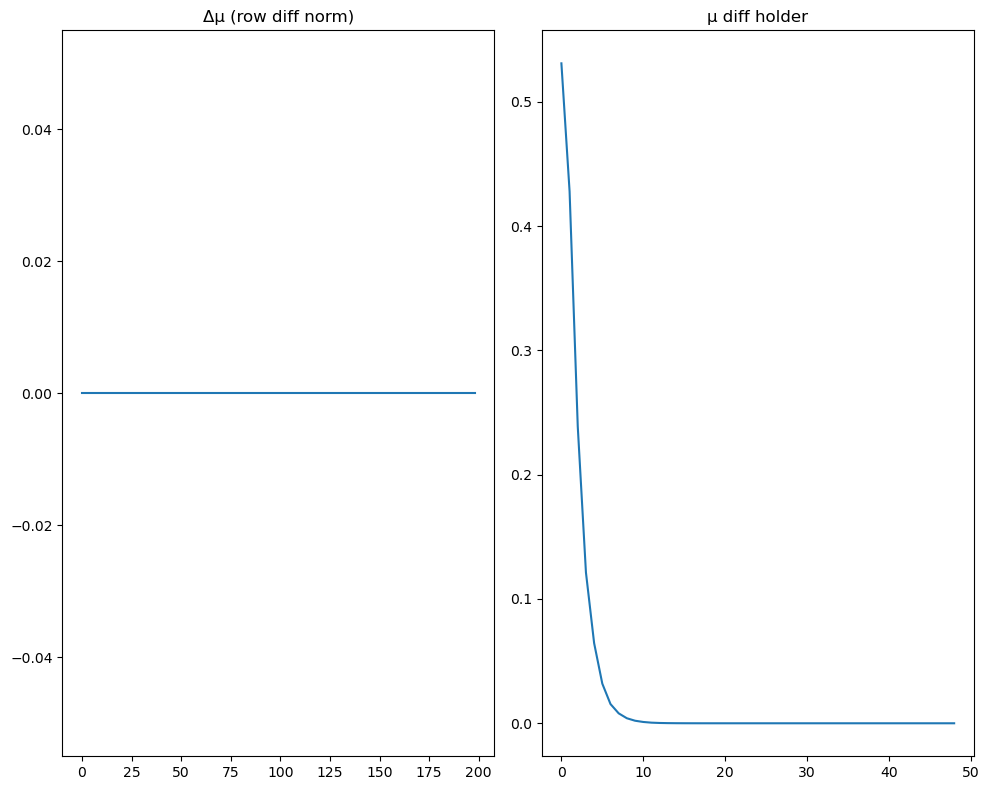

In [165]:
print(mu)
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# subplot 1: delta_mu
axes[0].plot(delta_mu)
axes[0].set_title("Δμ (row diff norm)")

# # subplot 2: log-likelihood
# axes[0,1].plot(loglik_train_holder[1:])
# axes[0,1].set_title("Training log-likelihood")

# subplot 3: mu difference holder
axes[1].plot(mu_diff_holder[1:])
axes[1].set_title("μ diff holder")

# # subplot 4: CV holder
# axes[1,1].plot(CV_holder)
# axes[1,1].set_title("CV holder")

plt.tight_layout()
plt.show()


In [148]:

############
# TRAINING #
############



def learn_one_seq_penalty(args,x_input, y_input, pen_iter, seq_iter, half):
  torch.manual_seed(1)
  
  m = args.num_samples
  kappa = args.kappa
  d = args.z_dim
  penalty = args.penalties[pen_iter]
  early_stopping = False
  stopping_count = 0 # for ADMM

  # if half:
  #   T = int(args.num_time/2)
  #   true_CP = args.true_CP_half
  #   label = 'half'
  # else:
  #   T = args.num_time
  #   true_CP = args.true_CP_full
  #   label = 'full'

  # create matrix X and vector 1
  ones_col = torch.ones(T, 1).to(device)
  X = torch.zeros(T, T-1).to(device)
  i, j = torch.tril_indices(T, T-1, offset=-1)
  X[i, j] = 1 # Group Fused Lasso

  old_loglik = -float('inf')
  loglik_train_holder = []
  loglik_test_holder = []
  mu_diff_holder = []
  decoder_loss_holder = []
  CV_holder = []


  # use Coefficient of Variation (CV) when half=True
  # save result based on Coefficient of Variation (CV)
  if not half:
    best_mu = torch.zeros(T,d)
    best_loglik = torch.zeros(1)
    best_CV = -float('inf') # Coefficient of Variation
    best_CV_iter = 0

  
  # initialize mu, nu, w, with dim T by d of zeros
  mu = torch.zeros(T, d).to(device)
  nu = torch.zeros(T, d).to(device)
  w = torch.zeros(T, d).to(device)
  
  mu_old = mu.detach().clone()
  nu_old = nu.detach().clone()


  # creat repeated version of ground truth, from (T by n by n) to (Tm by n by n)
  # repeat m for T times, giving [m, m, ..., m]
  # for each t in T (axis=0), repeat num_samples times, giving (Tm by n by n)
  # y_train_repeat = np.repeat(y_train.numpy(), np.repeat(m, T), axis=0) 
  # y_train_repeat = torch.from_numpy(y_train_repeat).to(device)

  # if half:
  #   # these objects exist if half = True
  #   y_test_repeat = np.repeat(y_test.numpy(), np.repeat(m, T), axis=0) 
  #   y_test_repeat = torch.from_numpy(y_test_repeat).to(device)


  model = CPD(args, half).to(device)
  model.apply(init_weights)
  optimizer = torch.optim.Adam(model.parameters(), lr=args.decoder_lr)
  criterion = nn.MSELoss(reduction='sum') # loglik sum over t, but expectation over m, so later divided by m
  
  for learn_iter in range(args.epoch):

    ####################
    # GENERATE SAMPLES #
    ####################
    # create repeated version of mu, from (T by d) to (Tm by d)
    mu_repeat = np.repeat(mu.cpu().numpy(), np.repeat(m, T), axis=0)
    mu_repeat = torch.from_numpy(mu_repeat).to(device) # Tm by d
    init_z = torch.randn(T*m, d).to(device) # Tm by d, starts from N(0,1)
    sampled_z_all = model.infer_z(x_input, init_z, y_input, mu_repeat, args) # Tm by d

    ################
    # UPDATE PRIOR # 
    ################
    expected_z = sampled_z_all.clone().reshape(T,m,d) # T by m by d
    expected_z = expected_z.mean(dim=1) # T by d
    mu = ( expected_z + kappa * (nu-w) ) / ( 1.0 + kappa )
    mu = mu.detach().clone()

    ##################
    # UPDATE DECODER #
    ##################
    inner_loss = float('inf')
    for decoder_iter in range(args.decoder_iteration):
      optimizer.zero_grad()
      pi, mean, sigma, covs  = model(x_input, sampled_z_all) # Tm by n by n 
      loss = mixture_of_gaussians_loss(y_input, pi, mean, covs) / m
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 1)
      optimizer.step()

    #########################
    # UPDATE BETA AND GAMMA #
    #########################

    gamma = nu[0, :].unsqueeze(0) # row vector
    beta = torch.diff(nu, dim=0)

    for nu_iter in range(args.nu_iteration):
      # update beta once (t range from 1 to 99, NOT 1 to 100)
      for t in range(T-1): 
        beta_without_t = beta.detach().clone()
        X_without_t = X.detach().clone()
        beta_without_t[t,:] = torch.zeros(d) # make this row zeros
        X_without_t[:,t] = torch.zeros(T) # make this column zeros
        bt = kappa * torch.mm( X[:,t].unsqueeze(0), mu + w - torch.mm(ones_col, gamma) - torch.mm(X_without_t, beta_without_t) )
        bt_norm = torch.norm(bt, p=2)

        # UPDATE: soft-thresholding
        if bt_norm < penalty:
          beta[t,:] = torch.zeros(d)
        else:
          beta[t,:] = 1 / (kappa * torch.norm(X[:,t], p=2)**2) * (1 - penalty/bt_norm) * bt
        beta = beta.detach().clone()

      # update gamma
      gamma = torch.mean(mu + w - torch.mm(X, beta), dim=0).unsqueeze(0).detach().clone()

    # recollect nu
    nu = torch.mm(ones_col, gamma) + torch.mm(X, beta)
    nu = nu.detach().clone()

    ############
    # UPDATE W # 
    ############

    w = mu - nu + w
    w = w.detach().clone()

    ############
    # RESIDUAL # 
    ############

    primal_residual = torch.sqrt(torch.mean(torch.square(mu - nu)))
    dual_residual = torch.sqrt(torch.mean(torch.square(nu - nu_old)))

    if primal_residual > 10.0 * dual_residual:
      kappa *= 2.0
      w *= 0.5
      print('\n[INFO] kappa increased to', kappa)
    elif dual_residual > 10.0 * primal_residual:
      kappa *= 0.5
      w *= 2.0
      print('\n[INFO] kappa decreased to', kappa)

    
    # calculate log_likelihood
    with torch.no_grad():
      # if half=False, adj_test_repeat does not exist
      # if half:
      #   loglik_train = model.cal_loglik(mu, y_train_repeat) # USE TRAIN
      #   loglik_train_holder.append(loglik_train.detach().cpu().numpy().item())
      #   loglik = model.cal_loglik(mu, adj_test_repeat) # USE TEST
      #   loglik_test_holder.append(loglik.detach().cpu().numpy().item())
      # else:
      #   loglik = model.cal_loglik(mu, adj_train_repeat) # USE TRAIN
      #   loglik_train_holder.append(loglik.detach().cpu().numpy().item())
      
      # criteria 1
      # loglik_relative_diff = torch.abs((loglik - old_loglik) / old_loglik)
      # old_loglik = loglik.detach().clone()
      

      # criteria 2
      mu_relative_diff = torch.norm(mu-mu_old, p='fro')
      mu_diff_holder.append(mu_relative_diff.detach().cpu().numpy().item())
      
      mu_old = mu.detach().clone()
      nu_old = nu.detach().clone()

    #####################
    # STOPPING CRITERIA #
    #####################
 
    # if loglik_relative_diff < args.loglik_thr:
    #   stopping_count += 1
    # else:
    #   stopping_count = 0

    # if stopping_count >= args.iter_thr:
    #   print('\n[INFO] early stopping')
    #   early_stopping = True



    ##############
    # PRINT INFO #
    ##############

    if (learn_iter+1) % 10 == 0:

      with torch.no_grad():
        # second row - first row
        delta_mu = torch.norm(torch.diff(mu, dim=0), p=2, dim=1)
        delta_mu = delta_mu.cpu().detach().numpy() # numpy for plot

        # plt.plot(delta_mu); plt.xticks(true_CP)
        # plt.savefig( output_dir + '/{}_delta_mu_seq{}pen{}_learn{}'.format(label,seq_iter,pen_iter,learn_iter+1) + '.png' ) 
        # plt.close()

        # if half: 
        #   plt.plot(loglik_train_holder[1:], label="train")
        #   plt.plot(loglik_test_holder[1:], label="test")
        #   plt.legend(loc="lower right")
        #   plt.savefig( output_dir + '/{}_loglik_seq{}pen{}'.format(label,seq_iter,pen_iter) + '.png' ) 
        #   plt.close()
        # else:
        #   plt.plot(loglik_train_holder[1:])
        #   plt.savefig( output_dir + '/{}_loglik_seq{}pen{}'.format(label,seq_iter,pen_iter) + '.png' ) 
        #   plt.close()

        # plt.plot(mu_diff_holder[1:])
        # plt.savefig( output_dir + '/{}_mu_diff_seq{}pen{}'.format(label,seq_iter,pen_iter) + '.png' ) 
        # plt.close()

        # if not half:
        #   plt.plot(CV_holder)
        #   plt.savefig( output_dir + '/{}_CV_seq{}pen{}'.format(label,seq_iter,pen_iter) + '.png' ) 
        #   plt.close()

        # print('\nlearning iter (seq={}, [penalty={}], data={}) ='.format(seq_iter,penalty,label), learn_iter+1, 'of', args.epoch)
        # print('\tlog likelihood =', loglik)
        print('\tprimal residual =', primal_residual)
        print('\tdual residual =', dual_residual)
        # print('\t\tlog likelihood relative difference =', loglik_relative_diff)
        print('\t\tmu relative difference =', mu_relative_diff)
      
    ###############
    # SAVE RESULT #
    ###############
    # at the last iteration or early_stopping
    # if (learn_iter+1) == args.epoch or early_stopping:
    #   print('\nFINAL learning iter (seq num = {}, [penalty={}]) ='.format(seq_iter,penalty), learn_iter+1, 'of', args.epoch)
    #   # print('FINAL log likelihood =', loglik)
    #   # print('FINAL log likelihood relative difference =', loglik_relative_diff)
    #   print('FINAL mu relative difference =', mu_relative_diff)

    #   with torch.no_grad():
    #     if half:
    #       # USE THE LAST MU
    #       delta_mu = torch.norm(torch.diff(mu, dim=0), p=2, dim=1)
    #       result = evaluation(delta_mu, args, loglik, pen_iter, seq_iter, output_dir, half)
    #       return torch.tensor(result[0:5]), loglik, mu
    #     else:
    #       # USE THE BEST MU
    #       print('[INFO] best_CV_iter =', best_CV_iter)
    #       delta_mu = torch.norm(torch.diff(best_mu, dim=0), p=2, dim=1)
    #       result = evaluation(delta_mu, args, best_loglik, pen_iter, seq_iter, output_dir, half)
    #       return torch.tensor(result[0:5]), best_loglik, best_mu, w_left, w_right



In [150]:
learn_one_seq_penalty(args, x_input, y_input, pen_iter=0, seq_iter=1, half=False)


[INFO] kappa increased to 20.0

[INFO] kappa increased to 40.0

[INFO] kappa increased to 80.0

[INFO] kappa increased to 160.0

[INFO] kappa increased to 320.0

[INFO] kappa increased to 640.0

[INFO] kappa increased to 1280.0

[INFO] kappa increased to 2560.0

[INFO] kappa increased to 5120.0

[INFO] kappa increased to 10240.0
	primal residual = tensor(3.08778e-05, device='cuda:0')
	dual residual = tensor(9.58394e-07, device='cuda:0')
		mu relative difference = tensor(0.00196, device='cuda:0')

[INFO] kappa increased to 20480.0

[INFO] kappa increased to 40960.0

[INFO] kappa increased to 81920.0

[INFO] kappa increased to 163840.0

[INFO] kappa increased to 327680.0

[INFO] kappa increased to 655360.0

[INFO] kappa increased to 1310720.0

[INFO] kappa increased to 2621440.0

[INFO] kappa increased to 5242880.0

[INFO] kappa increased to 10485760.0
	primal residual = tensor(3.10123e-08, device='cuda:0')
	dual residual = tensor(1.67730e-09, device='cuda:0')
		mu relative difference =